# Example 5 - Plug flow reactor yield

In this example, we will demonstrate how Bayesian Optimization can locate the optimal conditions for a plug flow reactor (PFR) and produce the maximum yield. The PFR model is developed for the acid-catalyzed dehydration of fructose to HMF using HCl as the catalyst. 


The analytical form of the objective function is encoded in the PFR model. It is a set of ordinary differential equations (ODEs). The input parameters (`X`) are 
- T - reaction temperature (°C)
- pH - reaction pH 
- tf - final residence time (min)

At each instance, the PFR model solves the ODEs and would return the steady state yield, i.e, the reponse `Y`.

The computational cost to solve the objective function is high. As a result, the trained Gaussian Process (GP) serves as an efficient surrogate model for prediction tasks. 

The details of this example is summarized in the table below:

| Key Item      | Description |
| :----------------- | :---------------------------- |
| Goal | Maximization |
| Objective function | PFR model |
| Input (X) dimension | 3 |
| Output (Y) dimension | 1 |
| Analytical form available? | Yes |
| Acqucision function | Expected improvement (EI) |
| Initial Sampling | Full factorial or latin hypercube | 

Next, we will go through each step in Bayesian Optimization.


## 1. Import `nextorch` and other packages

In [1]:
import os
import sys
import time
from IPython.display import display

project_path = os.path.abspath(os.path.join(os.getcwd(), '..\..'))
sys.path.insert(0, project_path)

# Set the path for objective function
objective_path = os.path.join(project_path, 'examples', 'PFR')
sys.path.insert(0, objective_path)

import numpy as np
from nextorch import plotting, bo, doe, utils, io

## 2. Define the objective function and the design space
We import the PFR model, and wrap it in a Python function called `PFR_yield` as the objective function `objective_func`. 
Note that it is suggested to put the return values of the objective function as a 2D numpy matrix instead of a 1D numpy array. We use `Y_real = np.expand_dims(Y_real, axis=1)` to expand the output's dimension.

The ranges of the input X are specified. 

In [2]:
#%% Define the objective function
from fructose_pfr_model_function import Reactor

def PFR_yield(X_real):
    """PFR model

    Parameters
    ----------
    X_real : numpy matrix
        reactor parameters: 
        T, pH and tf in real scales

    Returns
    -------
    Y_real: numpy matrix
        reactor yield 
    """
    if len(X_real.shape) < 2:
        X_real = np.expand_dims(X_real, axis=1) #If 1D, make it 2D array
        
    Y_real = []
    for i, xi in enumerate(X_real):
        Conditions = {'T_degC (C)': xi[0], 'pH': xi[1], 'tf (min)' : 10**xi[2]}
        yi, _ = Reactor(**Conditions) # only keep the first output       
        Y_real.append(yi)
            
    Y_real = np.array(Y_real)
    # Put y in a column
    Y_real = np.expand_dims(Y_real, axis=1)
        
    return Y_real # yield

# Objective function
objective_func = PFR_yield


#%% Define the design space
# Three input temperature C, pH, log10(residence time)
X_name_list = ['T', 'pH', r'$\rm log_{10}(tf_{min})$']
X_units = [r'$\rm ^{o}C $', '', '']

# Add the units
X_name_with_unit = []
for i, var in enumerate(X_name_list):
    if not X_units[i]  == '':
        var = var + ' ('+ X_units[i] + ')'
    X_name_with_unit.append(var)
    
# One output
Y_name_with_unit = 'Yield %'

# combine X and Y names
var_names = X_name_with_unit + [Y_name_with_unit]

# Set the operating range for each parameter
X_ranges =  [[140, 200], # Temperature ranges from 140-200 degree C
             [0, 1], # pH values ranges from 0-1 
             [-2, 2]] # log10(residence time) ranges from -2-2  

# Set the reponse range
Y_plot_range = [0, 50]

# Get the information of the design space
n_dim = len(X_name_list) # the dimension of inputs
n_objective = 1 # the dimension of outputs

## 3. Define the initial sampling plan
Here we compare two sampling plans with the same number of sampling points:

1. Full factorial (FF) design with levels of 5 and 125 points in total. 
2. Latin hypercube (LHC) design with 10 initial sampling points, and 115 more Bayesian Optimization trials

The initial reponse in a real scale `Y_init_real` is computed from the helper function `bo.eval_objective_func(X_init, X_ranges, objective_func)`, given `X_init` in unit scales. It might throw warning messages since the model solves some edge cases of ODEs given certain input combinations. 

C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


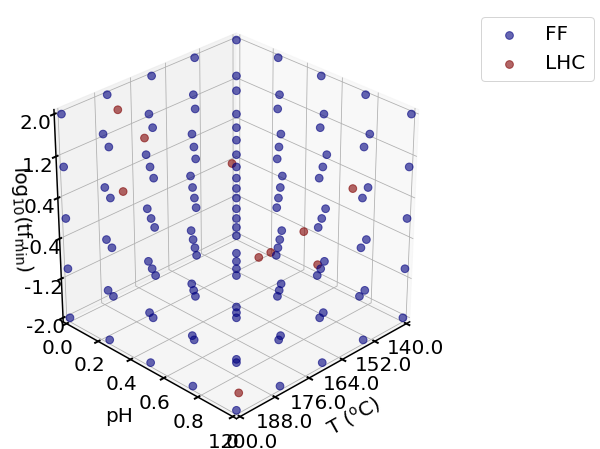

In [3]:
#%% Initial Sampling 
# Full factorial design 
n_ff_level = 5
n_ff = n_ff_level**n_dim
X_init_ff = doe.full_factorial([n_ff_level, n_ff_level, n_ff_level])
# Get the initial responses
Y_init_ff = bo.eval_objective_func(X_init_ff, X_ranges, objective_func)

# Latin hypercube design with 10 initial points
n_init_lhc = 10
X_init_lhc = doe.latin_hypercube(n_dim = n_dim, n_points = n_init_lhc, seed= 1)
# Get the initial responses
Y_init_lhc = bo.eval_objective_func(X_init_lhc, X_ranges, objective_func)

# Compare the two sampling plans
plotting.sampling_3d([X_init_ff, X_init_lhc], 
                     X_names = X_name_with_unit,
                     X_ranges = X_ranges,
                     design_names = ['FF', 'LHC'])

## 4. Initialize an `Experiment` object 

Next, we initialize two `Experiment` objects for FF and LHC, respectively. We also set the objective function and the goal as maximization. 

We will train two GP models. Some progress status will be printed out.



In [4]:
#%% Initialize an Experiment object
# Set its name, the files will be saved under the folder with the same name
Exp_ff = bo.Experiment('PFR_yield_ff') 
# Import the initial data
Exp_ff.input_data(X_init_ff, Y_init_ff, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_ff.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)


# Set its name, the files will be saved under the folder with the same name
Exp_lhc = bo.Experiment('PFR_yield_lhc') 
# Import the initial data
Exp_lhc.input_data(X_init_lhc, Y_init_lhc, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_lhc.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)

Iter 10/100: 1.4488481283187866
Iter 20/100: 1.2887123823165894
Iter 30/100: 1.0179792642593384
Iter 40/100: 0.058627091348171234
Iter 10/100: 2.1498360633850098
Iter 20/100: 2.020167350769043
Iter 30/100: 1.9116523265838623


## 5. Run trials 
We perform 115 more Bayesian Optimization trials for the LHC design using the default acquisition function (Expected Improvement (EI)). 

In [5]:
#%% Optimization loop
# Set the number of iterations  
n_trials_lhc = n_ff - n_init_lhc
for i in range(n_trials_lhc):
    # Generate the next experiment point
    X_new, X_new_real, acq_func = Exp_lhc.generate_next_point()
    # Get the reponse at this point
    Y_new_real = objective_func(X_new_real) 
    # or 
    # Y_new_real = bo.eval_objective_func(X_new, X_ranges, objective_func)

    # Retrain the model by input the next point into Exp object
    Exp_lhc.run_trial(X_new, X_new_real, Y_new_real)

Iter 10/100: 1.6363911628723145
Iter 20/100: 1.614909291267395
Iter 30/100: 1.606312870979309
Iter 40/100: 1.6000746488571167
Iter 50/100: 1.5963369607925415
Iter 60/100: 1.5927354097366333
Iter 70/100: 1.5900384187698364
Iter 80/100: 1.5882267951965332
Iter 90/100: 1.5869585275650024
Iter 100/100: 1.5859788656234741
Iter 10/100: 1.562159776687622
Iter 20/100: 1.5548175573349
Iter 30/100: 1.5468826293945312
Iter 40/100: 1.5420504808425903
Iter 10/100: 1.7370423078536987
Iter 20/100: 1.6855124235153198
Iter 10/100: 0.7914197444915771
Iter 20/100: 0.7714166045188904
Iter 10/100: 0.4594327211380005


C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


## 6. Visualize the final model reponses
We would like to see how sampling points scattered in the 3D space. A 2D slices of the 3D space is visualized below at a fixed x value . 

LHC sampling points


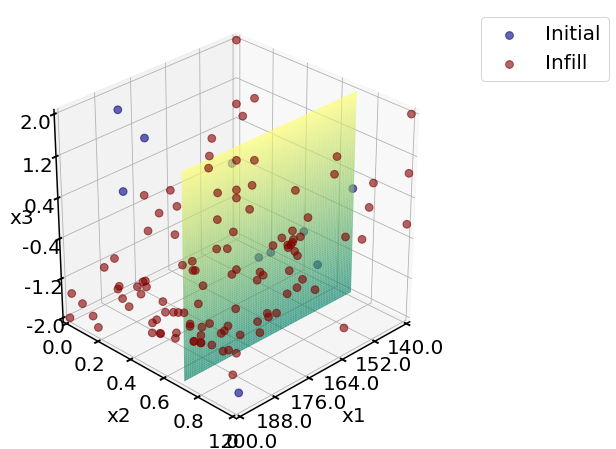

Comparing two plans: 


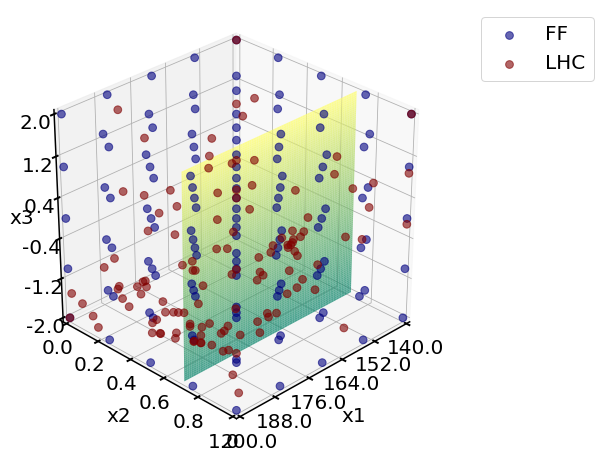

In [6]:
#%% plots 
# Check the sampling points
# Final lhc Sampling
x2_fixed_real = 0.7 # fixed x2 value
x_indices = [0, 2] # 0-indexing, for x1 and x3
print('LHC sampling points')
plotting.sampling_3d_exp(Exp_lhc, 
                         slice_axis = 'y', 
                         slice_value_real = x2_fixed_real)    
                         
# Compare to full factorial
print('Comparing two plans: ')
plotting.sampling_3d([Exp_ff.X, Exp_lhc.X], 
                     X_ranges = X_ranges,
                     design_names = ['FF', 'LHC'],
                     slice_axis = 'y', 
                     slice_value_real = x2_fixed_real)

By fixing the value of pH (`x2`), we can plot the 2D reponse surfaces by varying T (`x1`) and tf (`x3`). It takes a long time to get the reponses from the objective function. 

To create a heatmap, we generate `mesh_size` (by default = 41, here we set it as 20) test points along one dimension. For a 2D mesh, 20 by 20, i.e. 400 times of evaluation is needed. The following code indicates that evaluting the GP surrogate model is much faster than calling the objective function. 

Objective function heatmap: 


C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


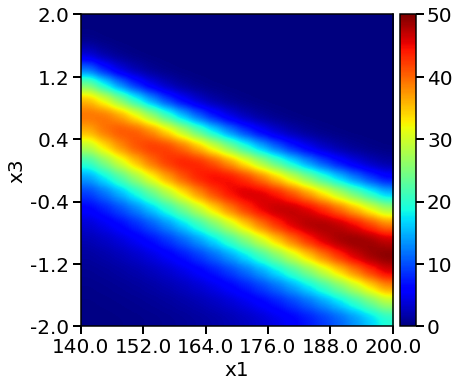

Evaluation of objective function 400 times takes 0.15 min

LHC model heatmap: 


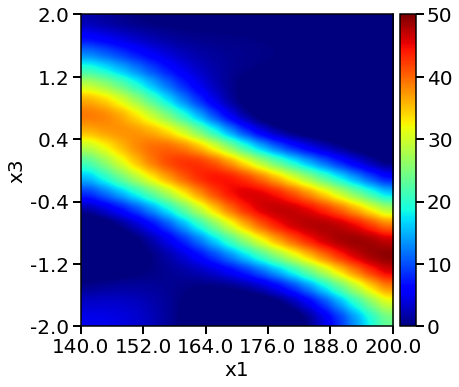

Evaluation of LHC GP model 400 times takes 0.00 min

Full factorial model heatmap: 


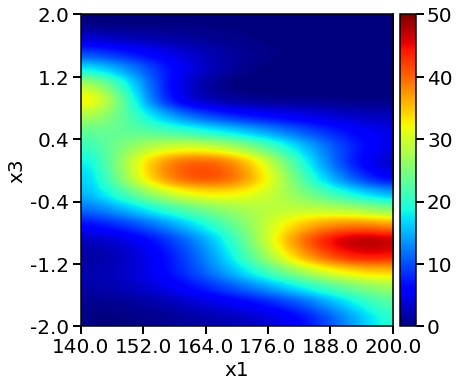

Evaluation of FF GP model 400 times takes 0.01 min



In [7]:
# Reponse heatmaps
# Set X_test mesh size
mesh_size = 20
n_test = mesh_size**2

# Objective function heatmap
# (this takes a long time)
print('Objective function heatmap: ')
start_time = time.time()
plotting.objective_heatmap(objective_func, 
                          X_ranges, 
                          Y_real_range = Y_plot_range, 
                          x_indices = x_indices, 
                          fixed_values_real = x2_fixed_real,
                          mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of objective function {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

# LHC heatmap 
print('LHC model heatmap: ')
start_time = time.time()
plotting.response_heatmap_exp(Exp_lhc, 
                              Y_real_range = Y_plot_range, 
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of LHC GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

# full factorial heatmap
print('Full factorial model heatmap: ')
start_time = time.time()
plotting.response_heatmap_exp(Exp_ff, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of FF GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60)) 

The rates can also be plotted as response surfaces in 3D.

Objective function surface: 


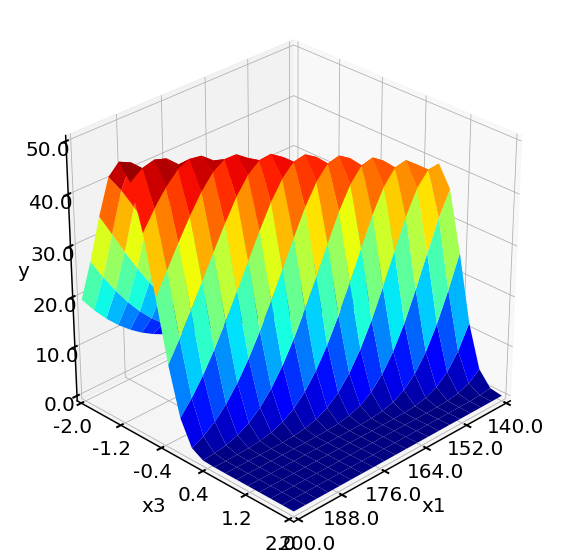

Evaluation of objective function 400 times takes 0.14 min

Full fatorial model surface: 


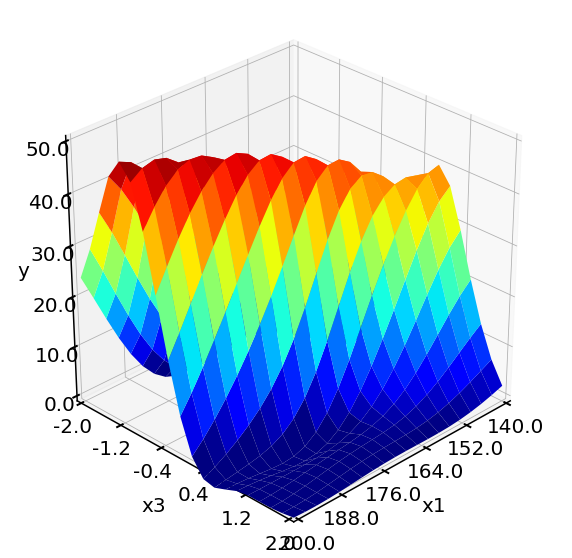

Evaluation of LHC GP model 400 times takes 0.00 min

LHC model surface: 


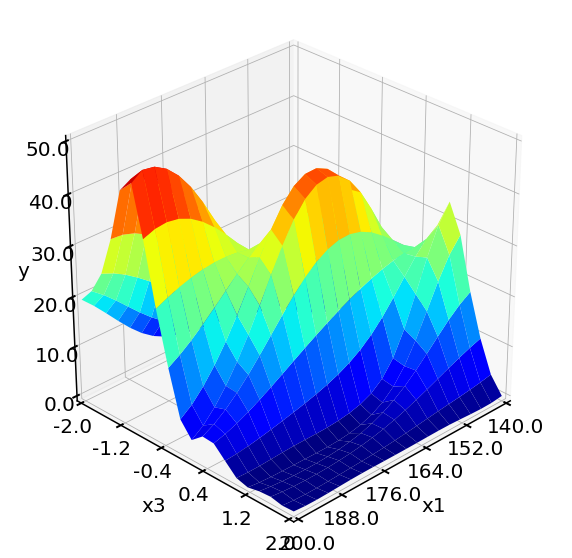

Evaluation of FF GP model 400 times takes 0.00 min



In [8]:
# Suface plots   
# Objective function surface plot  
#(this takes a long time)
print('Objective function surface: ')
start_time = time.time()
plotting.objective_surface(objective_func, 
                          X_ranges, 
                          Y_real_range = Y_plot_range, 
                          x_indices = x_indices, 
                          fixed_values_real = x2_fixed_real, 
                          mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of objective function {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

# LHC surface plot
print('Full fatorial model surface: ')
start_time = time.time()
plotting.response_surface_exp(Exp_lhc, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of LHC GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))


# full fatorial surface plot
print('LHC model surface: ')
start_time = time.time()
plotting.response_surface_exp(Exp_ff, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of FF GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60)) 


## 7. Export the optimum

Compare two plans in terms optimum discovered in each trial.

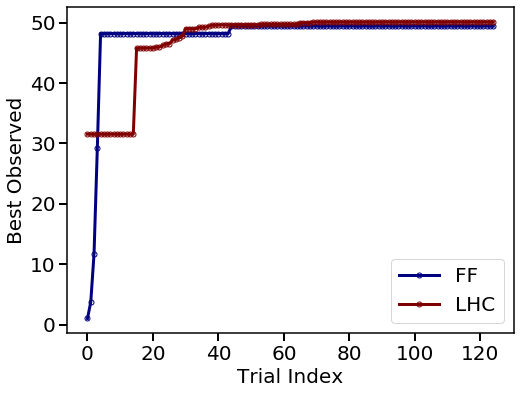

In [9]:
plotting.opt_per_trial([Exp_ff.Y_real, Exp_lhc.Y_real], 
                       design_names = ['FF', 'LHC'])

Obtain the optimum from each method. 

In [10]:
# lhc optimum
y_opt_lhc, X_opt_lhc, index_opt_lhc = Exp_lhc.get_optim()
data_opt_lhc = io.np_to_dataframe([X_opt_lhc, y_opt_lhc], var_names)

print('From LHC + Bayesian Optimization, ')
display(data_opt_lhc)

# FF optimum
y_opt_ff, X_opt_ff, index_opt_ff = Exp_ff.get_optim()
data_opt_ff = io.np_to_dataframe([X_opt_ff, y_opt_ff], var_names)

print('From full factorial design, ')
display(data_opt_ff)

From LHC + Bayesian Optimization, 


,T ($\rm ^{o}C $),pH,$\rm log_{10}(tf_{min})$,Yield %
0,200.0,0.861353,-0.979011,50.101374


From full factorial design, 


,T ($\rm ^{o}C $),pH,$\rm log_{10}(tf_{min})$,Yield %
0,200.0,0.75,-1.0,49.421608


From above plots, we see the response surface produced by LHC + Bayesian Optimization is more accurate and resembles the one from the objective function. The method also locates a higher yield value compared to the full factorial design. We can conclude that LHC + Bayesian Optimization is efficient in locating the optimum and produce accurate surrogate models at affordable computational cost. 

## References:
1. Desir, P.; Saha, B.; Vlachos, D. G. Energy Environ. Sci. 2019.

2. Swift, T. D.; Bagia, C.; Choudhary, V.; Peklaris, G.; Nikolakis, V.; Vlachos, D. G. ACS Catal. 2014, 4 (1), 259–267

3. The PFR model can be found on GitHub: https://github.com/VlachosGroup/Fructose-HMF-Model

[Thumbnail](_images/05.png) of this notebook